Created: 7/1/2025

Purpose: Exploratory Data analysis on the generated model dataset

In [1]:
# import libraries and functions

from heatmap_analysis import Report, gather_model_paths, load_references, open_log, step_file_system, MemModel
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import cv2
from skimage.metrics import structural_similarity

This is the setup to load dataset into memory for further analysis

In [2]:
class_path = "D:\\model_dataset\\classification"
regress_path = "D:\\model_dataset\\regression"
model_paths = gather_model_paths(class_path, regress_path)
class_models = load_references(model_paths[1])
regress_models = load_references(model_paths[0])
class_logs_agg = []
regress_logs_agg = []
class_by_dataset = {}
regress_by_dataset = {}

# Gather the data for the classification models
for model in class_models:
    log = open_log(model.model_path)
    class_logs_agg.append(log)
    rows = model.model_path.split('\\')[-2]
    if rows in class_by_dataset:
        class_by_dataset[rows].append(log)
    else:
        class_by_dataset.update({rows: [log]})

#Gather the data for the regression models
for model in regress_models:
    log = open_log(model.model_path)
    regress_logs_agg.append(log)
    rows = model.model_path.split('\\')[-2]
    if rows in regress_by_dataset:
        regress_by_dataset[rows].append(log)
    else:
        regress_by_dataset.update({rows: [log]})

In [3]:
class_data = pd.DataFrame(class_by_dataset)
class_agg = pd.Series(class_logs_agg)
regress_agg = pd.Series(regress_logs_agg)
regress_data = pd.DataFrame(regress_by_dataset)

In [4]:
temp_c_data = copy.deepcopy(class_by_dataset)
temp_r_data = copy.deepcopy(regress_by_dataset)
class_format_data = {}
regress_format_data = {}
for key in temp_c_data:
    optimizers_regress_dict = {}
    optimizers_class_dict = {}
    class_logs = temp_c_data[key]
    regress_logs = temp_r_data[key]
    for index, item in enumerate(regress_logs):
        class_opt = class_logs[index]
        if item.optimizer in list(optimizers_regress_dict.keys()):
            optimizers_regress_dict[item.optimizer].append(item.accuracy)
        else:
            optimizers_regress_dict.update({item.optimizer: [item.accuracy]})
        if class_opt.optimizer in list(optimizers_class_dict.keys()):
            optimizers_class_dict[class_opt.optimizer].append(class_opt.accuracy)
        else:
            optimizers_class_dict.update({class_opt.optimizer: [class_opt.accuracy]})
    regress_format_data.update({key: optimizers_regress_dict})
    class_format_data.update({key: optimizers_class_dict})
for data_key in class_format_data:
    for optim_key in class_format_data[data_key]:
        print(f"Descriptive stats for {optim_key} on classification datatset with {data_key}: {pd.Series(class_format_data[data_key][optim_key]).describe()}")
        print(f"Descriptive stats for {optim_key} on regression datatset with {data_key}: {pd.Series(regress_format_data[data_key][optim_key]).describe()}")

Descriptive stats for <class 'torch.optim.adam.Adam'> on classification datatset with 10000_rows: count    23.000000
mean      0.187685
std       0.011305
min       0.156468
25%       0.182741
50%       0.191033
75%       0.195817
max       0.199922
dtype: float64
Descriptive stats for <class 'torch.optim.adam.Adam'> on regression datatset with 10000_rows: count    24.000000
mean     12.715041
std       8.038495
min       0.010231
25%       8.511768
50%      12.530066
75%      15.910588
max      33.794425
dtype: float64
Descriptive stats for <class 'torch.optim.asgd.ASGD'> on classification datatset with 10000_rows: count    24.000000
mean      0.305834
std       0.131135
min       0.195484
25%       0.197481
50%       0.237125
75%       0.386363
max       0.613276
dtype: float64
Descriptive stats for <class 'torch.optim.asgd.ASGD'> on regression datatset with 10000_rows: count    23.000000
mean     13.773887
std       3.397902
min       4.236516
25%      13.799790
50%      15.111955
7

In [4]:
temp_agg = class_agg.copy().to_numpy()
temp_r_agg = regress_agg.copy().to_numpy()
optimizers_dict = {}
for index, item in enumerate(temp_r_agg):
    class_opt = temp_agg[index].optimizer
    if item.optimizer in list(optimizers_dict.keys()):
        optimizers_dict[item.optimizer] += 1
    else:
        optimizers_dict.update({item.optimizer: 1})
    if class_opt in list(optimizers_dict.keys()):
        optimizers_dict[class_opt] += 1
    else:
        optimizers_dict.update({class_opt: 1})
print(optimizers_dict)

{"<class 'torch.optim.sgd.SGD'>": 404, "<class 'torch.optim.adam.Adam'>": 390, "<class 'torch.optim.asgd.ASGD'>": 386, "<class 'torch.optim.rmsprop.RMSprop'>": 420}


Note: Seems the dataset is biased towards the RMSProp optimizer, but not by a huge margin.

In [25]:
temp_agg = class_agg.copy().to_numpy()
temp_r_agg = regress_agg.copy().to_numpy()
optimizers_regress_dict = {}
optimizers_class_dict = {}
for index, item in enumerate(temp_r_agg):
    class_opt = temp_agg[index]
    if item.optimizer in list(optimizers_regress_dict.keys()):
        optimizers_regress_dict[item.optimizer].append(item.accuracy)
    else:
        optimizers_regress_dict.update({item.optimizer: [item.accuracy]})
    if class_opt.optimizer in list(optimizers_class_dict.keys()):
        optimizers_class_dict[class_opt.optimizer].append(class_opt.accuracy)
    else:
        optimizers_class_dict.update({class_opt.optimizer: [class_opt.accuracy]})
print(optimizers_class_dict)
print(optimizers_regress_dict)
for class_key in optimizers_class_dict:
    print(f"Descriptive Stats on BCELoss for {class_key}:\n\t {pd.Series(optimizers_class_dict[class_key]).describe()}")
for regress_key in optimizers_regress_dict:
    print(f"Descriptive Stats on MSELoss for {regress_key}:\n\t {pd.Series(optimizers_regress_dict[regress_key]).describe()}")

{"<class 'torch.optim.adam.Adam'>": [0.19095044247806073, 0.19210295733064414, 0.19103337600827217, 0.17764861267060042, 0.1994794026017189, 0.19602566491812468, 0.1999215031042695, 0.19574149372056127, 0.18166141044348477, 0.19260097527876496, 0.1984944211319089, 0.19175176192075014, 0.1816417548805475, 0.15646829847246407, 0.19614697936922312, 0.18736496847122908, 0.19158799406141042, 0.18166359476745128, 0.1855618730187416, 0.1589671216905117, 0.19589311629533768, 0.1902235297486186, 0.18381822891533375, 0.50465819639309, 0.19190782432754835, 0.19604256469756365, 0.19003963780899844, 0.18198642553761601, 0.19726972297454873, 0.18579809887645146, 0.1939192971525093, 0.6640939330488133, 0.19943936805551252, 0.19900039614488682, 0.19902015027279654, 0.4311271090021667, 0.1974139683879912, 0.19894713846345743, 0.5316610627730066, 0.198163993190974, 0.19331787837048373, 0.19457737592359384, 0.19196183818082016, 0.17719423901289702, 0.19686094795664152, 0.18536949940025807, 0.175500580544

In [16]:
temp_agg = class_agg.copy().to_numpy()
temp_r_agg = regress_agg.copy().to_numpy()
optimizers_regress_dict = {}
optimizers_class_dict = {}
for index, item in enumerate(temp_r_agg):
    class_opt = temp_agg[index]
    if item.optimizer in list(optimizers_regress_dict.keys()):
        optimizers_regress_dict[item.optimizer].append(item.epochs)
    else:
        optimizers_regress_dict.update({item.optimizer: [item.epochs]})
    if class_opt.optimizer in list(optimizers_class_dict.keys()):
        optimizers_class_dict[class_opt.optimizer].append(class_opt.epochs)
    else:
        optimizers_class_dict.update({class_opt.optimizer: [class_opt.epochs]})
print(optimizers_class_dict)
print(optimizers_regress_dict)
for class_key in optimizers_class_dict:
    print(f"Descriptive Stats on Epochs for {class_key}:\n {pd.Series(optimizers_class_dict[class_key]).describe()}")
for regress_key in optimizers_regress_dict:
    print(f"Descriptive Stats on Epochs for {regress_key}:\n {pd.Series(optimizers_regress_dict[regress_key]).describe()}")

{"<class 'torch.optim.adam.Adam'>": [2, 9, 7, 3, 15, 1, 2, 2, 2, 7, 2, 3, 3, 2, 15, 8, 3, 2, 10, 2, 2, 3, 4, 30, 4, 9, 4, 5, 5, 5, 2, 30, 14, 9, 3, 30, 3, 19, 30, 3, 12, 5, 2, 2, 12, 2, 5, 2, 2, 1, 1, 2, 13, 4, 4, 12, 1, 2, 6, 2, 5, 3, 12, 11, 11, 4, 1, 3, 1, 1, 1, 3, 1, 2, 2, 1, 1, 3, 1, 2, 2, 7, 1, 1, 1, 3, 4, 3, 1, 3, 3, 2, 7, 11, 30, 5, 30, 30, 19, 19, 5, 14, 2, 30, 30, 30, 30, 30, 30, 30, 13, 30, 30, 9, 30, 30, 15, 30, 7, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 19, 30, 30, 30, 13, 30, 30, 30, 4, 29, 13, 16, 13, 30, 17, 10, 30, 9, 14, 3, 4, 4, 10, 3, 4, 4, 5, 20, 2, 22, 4, 2, 3, 5, 10, 8, 4, 4, 8, 11, 30, 2, 19, 8], "<class 'torch.optim.asgd.ASGD'>": [30, 19, 21, 30, 15, 20, 30, 18, 30, 20, 20, 30, 30, 19, 18, 30, 14, 30, 30, 29, 30, 30, 30, 23, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 29, 30, 30, 27, 30, 30, 30, 30, 30, 30, 30, 21, 30, 19, 13, 12, 15, 30, 30, 16, 30, 11, 30, 19, 30, 24, 30, 13, 

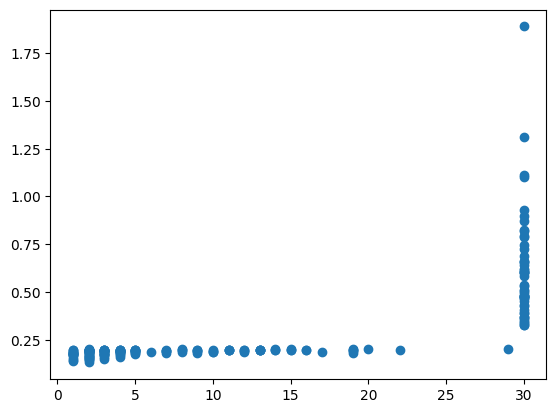

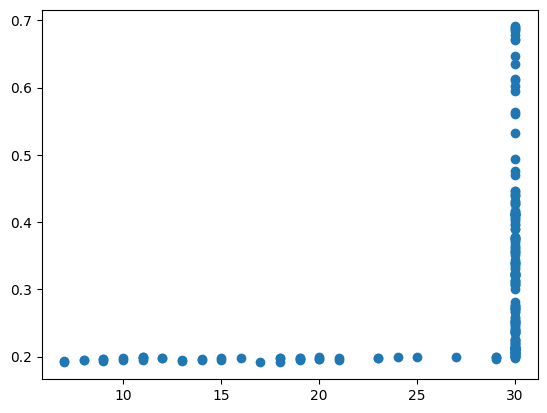

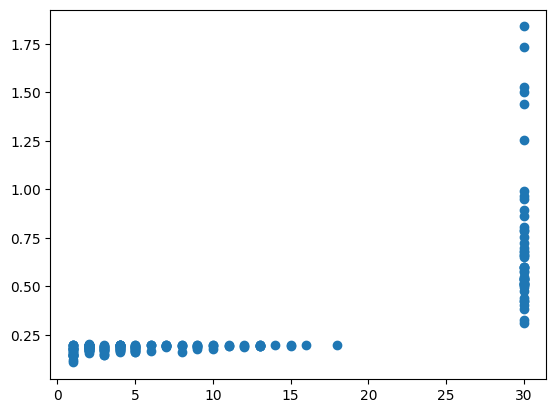

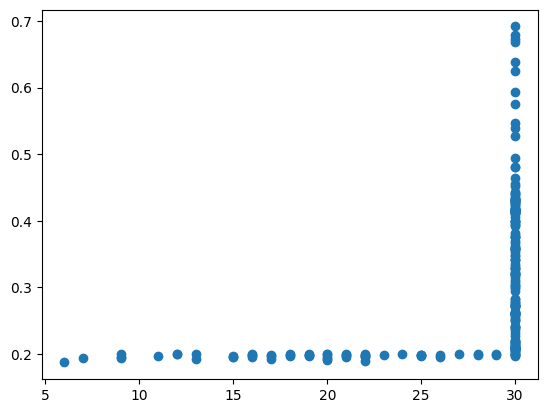

In [26]:
temp_agg = class_agg.copy().to_numpy()
temp_r_agg = regress_agg.copy().to_numpy()
optimizers_regress_dict = {}
optimizers_class_dict = {}
for index, item in enumerate(temp_r_agg):
    class_opt = temp_agg[index]
    if item.optimizer in list(optimizers_regress_dict.keys()):
        optimizers_regress_dict[item.optimizer].append((item.accuracy, item.epochs))
    else:
        optimizers_regress_dict.update({item.optimizer: [(item.accuracy, item.epochs)]})
    if class_opt.optimizer in list(optimizers_class_dict.keys()):
        optimizers_class_dict[class_opt.optimizer].append((class_opt.accuracy, class_opt.epochs))
    else:
        optimizers_class_dict.update({class_opt.optimizer: [(class_opt.accuracy, class_opt.epochs)]})
fig_num = 0
for value in list(optimizers_class_dict.values()):
    x_vals = []
    y_vals = []
    for x_y_tups in value:
        x_vals.append(x_y_tups[1])
        y_vals.append(x_y_tups[0])
    fig = plt.figure(fig_num)
    plt.scatter(x_vals, y_vals)
    plt.show()
    fig_num += 1 


In [2]:
def open_model(problem_type: str, data_rows: int, id: int) -> tuple[MemModel, Report]:
    path = "D:\\model_dataset\\" + problem_type + "\\" + str(data_rows) + "_rows\\" + "model_" + str(id)
    report_log = open_log(path)
    model = MemModel(path)
    return (model, report_log)

def display_select_model(p_type, rows, identity) -> None:
    mod, rep = open_model(p_type, rows, identity) 
    pre = mod.load_base_model()[0]
    post = mod.load_base_model(False)[0]
    fig_num = 0
    for index, weight in enumerate(pre):
            fig = plt.figure(fig_num)
            plt.imshow(weight)
            plt.axis('off')
            fig.canvas.draw()
            pre_image = cv2.cvtColor(np.asarray(fig.canvas.buffer_rgba()), cv2.COLOR_RGBA2GRAY)
            # cv2.imshow("Pre image", pre_image)
            fig_num += 1
            fig = plt.figure(fig_num)
            plt.imshow(post[index])
            plt.axis('off')
            fig.canvas.draw()
            post_image = cv2.cvtColor(np.asarray(fig.canvas.buffer_rgba()), cv2.COLOR_RGBA2GRAY)    
            # cv2.imshow("Post image", post_image)
            fig_num += 1
            similar_score = structural_similarity(pre_image, post_image, full=True)
            print(f"For layer {index}, the similarity score is: {similar_score[0]*100}")
            plt.show()
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()

def display_part(p_type, rows, identity, show_pre, show_post) -> Report:
    mod, rep = open_model(p_type, rows, identity) 
    pre = mod.load_base_model()[0]
    post = mod.load_base_model(False)[0]
    fig_num = 0
    for index, weight in enumerate(pre):
        if show_pre:
            fig = plt.figure(fig_num)
            plt.imshow(weight)
            plt.axis('off')
            fig.canvas.draw()
            # cv2.imshow("Pre image", pre_image)
            fig_num += 1
        if show_post:
            fig = plt.figure(fig_num)
            plt.imshow(post[index])
            plt.axis('off')
            fig.canvas.draw()
            # cv2.imshow("Post image", post_image)
            fig_num += 1
        plt.show()
    return rep


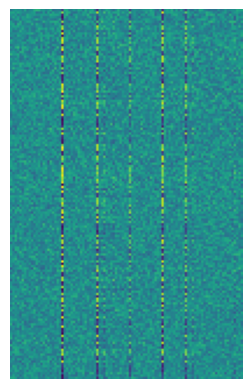

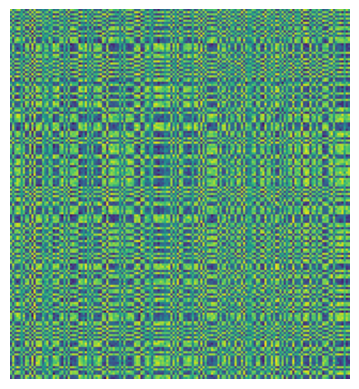

True optimizer: <class 'torch.optim.adam.Adam'>
True problem: regression
Model Info: regression, 7000, 51


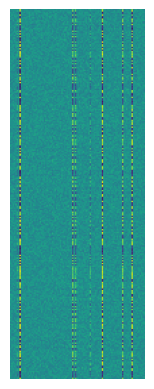

True optimizer: <class 'torch.optim.rmsprop.RMSprop'>
True problem: regression
Model Info: regression, 15000, 83


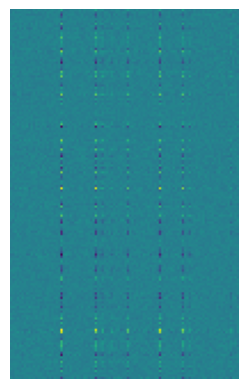

True optimizer: <class 'torch.optim.asgd.ASGD'>
True problem: regression
Model Info: regression, 7000, 15


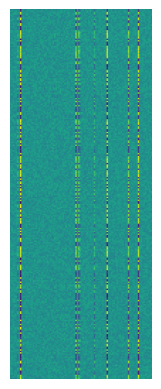

True optimizer: <class 'torch.optim.adam.Adam'>
True problem: regression
Model Info: regression, 15000, 93


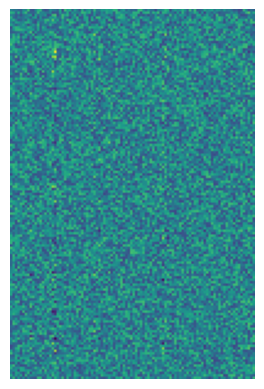

True optimizer: <class 'torch.optim.asgd.ASGD'>
True problem: classification
Model Info: classification, 2000, 97


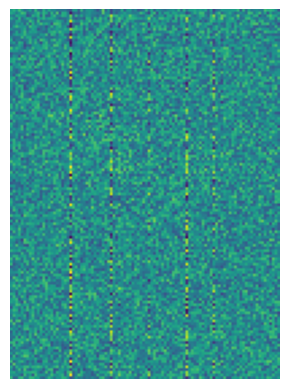

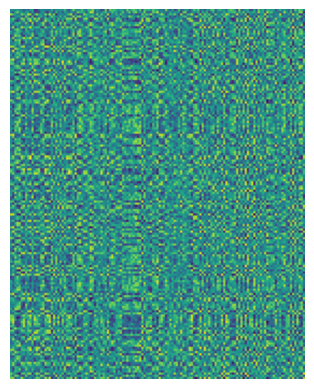

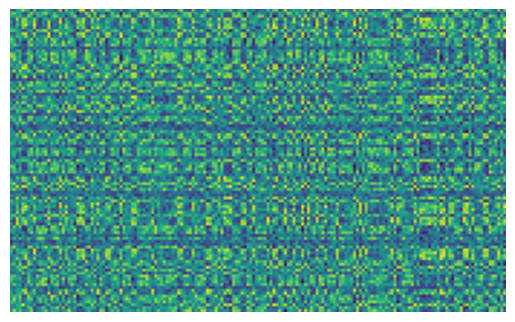

True optimizer: <class 'torch.optim.rmsprop.RMSprop'>
True problem: regression
Model Info: regression, 7000, 77


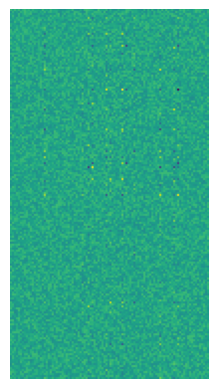

True optimizer: <class 'torch.optim.sgd.SGD'>
True problem: classification
Model Info: classification, 15000, 47


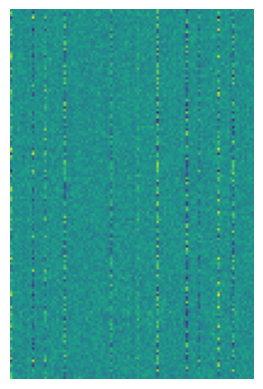

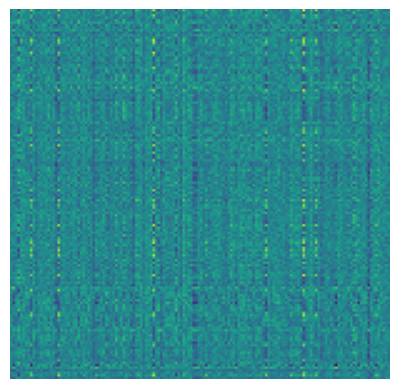

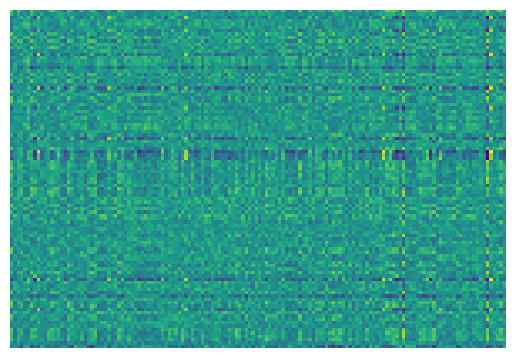

True optimizer: <class 'torch.optim.rmsprop.RMSprop'>
True problem: classification
Model Info: classification, 7000, 63


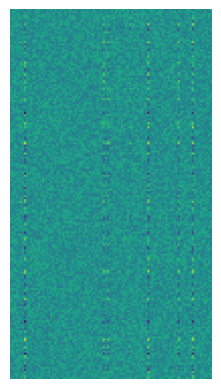

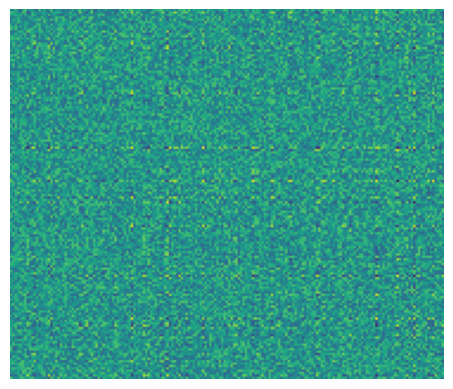

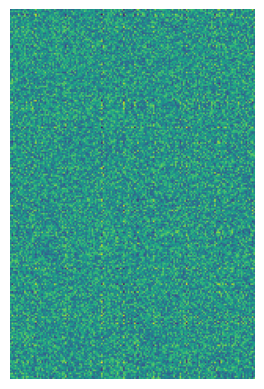

True optimizer: <class 'torch.optim.asgd.ASGD'>
True problem: regression
Model Info: regression, 15000, 94


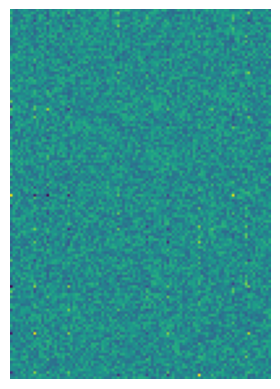

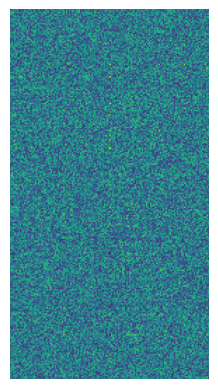

True optimizer: <class 'torch.optim.sgd.SGD'>
True problem: classification
Model Info: classification, 7000, 60
Final problem guess correct percentage: 70.00
Final optimizer guess correct percentage: 30.00


In [ ]:
# 8/21/2025
# Quiz based on
import random 

def convert_input(user_in):
    if user_in == "Adam":
        return "<class 'torch.optim.adam.Adam'>"
    elif user_in == "RMSProp":
        return "<class 'torch.optim.rmsprop.RMSProp'>"
    elif user_in == "ASGD":
        return "<class 'torch.optim.asgd.ASGD'>"
    else:
        return "<class 'torch.optim.sgd.SGD'>"

num_questions = int(input("Enter Number of Questions: "))
q_count = 0
problem_correct = 0
optimizer_correct = 0
while q_count != num_questions:
    p_type = random.choice(["classification", "regression"])
    row_amount = random.choice([2000, 5000, 7000, 10000, 12000, 15000, 17000, 20000])
    id_num = random.randint(0, 99)
    rep = display_part(p_type, row_amount, id_num, False, True)
    optim_guess = convert_input(input("Which optimizer was used? "))
    problem_guess = input("Which problem did this network solve? ")
    problem_correct += 1 if problem_guess == p_type else 0
    optimizer_correct += 1 if optim_guess == rep.optimizer else 0
    print(f"True optimizer: {rep.optimizer}")
    print(f"True problem: {p_type}")
    print(f"Model Info: {p_type}, {row_amount}, {id_num}")
    q_count += 1
print(f"Final problem guess correct percentage: {(problem_correct/num_questions)*100:.2f}")
print(f"Final optimizer guess correct percentage: {(optimizer_correct/num_questions)*100:.2f}")